In [48]:
from sigvisa.treegp.bcm.multi_shared_bcm import MultiSharedBCM, Blocker, sample_synthetic
from sigvisa.utils.geog import dist_km


In [8]:
def xcorr_valid(a,b):
    a = (a - np.mean(a)) / (np.std(a) * np.sqrt(len(a)))
    b = (b - np.mean(b)) / (np.std(b) * np.sqrt(len(a)))

    xc = my_xc(a, b)
    xcmax = np.max(xc)
    offset = np.argmax(xc)
    return xcmax, offset, xc

import scipy.weave as weave
from scipy.weave import converters
def my_xc(a, b):
    # assume len(a) < len(b)
    n = len(b) - len(a)+1
    m = len(a)
    r = np.zeros((n,))
    a_normed = a / np.linalg.norm(a)
    code="""
for(int i=0; i < n; ++i) {
    double b_norm = 0;
    double cc = 0;
    for (int j=0; j < m; ++j) {
        cc += a_normed(j)*b(i+j);
        b_norm += b(i+j)*b(i+j);
    }
    cc /= sqrt(b_norm);
    r(i) = cc;
}
"""
    weave.inline(code,['n', 'm', 'a_normed', 'b', 'r',],type_converters = converters.blitz,verbose=2,compiler='gcc')
    """
    for i in range(n):
        window = b[i:i+len(a)]
        w_normed = window / np.linalg.norm(window)
        r[i] = np.dot(a_normed, w_normed)
    """
    return r




In [5]:
import cPickle as pickle

def load_events(sta="mkar"):
    s = []
    for i in range(1, 100):
        try:
            with open("/home/dmoore/p_waves/%s_stuff_%d" % (sta, i * 1000), 'rb') as f:
                ss = pickle.load(f)
                s += ss
            print "loaded", i
        except IOError:
            with open("/home/dmoore/p_waves/%s_stuff_final" % (sta,), 'rb') as f:
                ss = pickle.load(f)
                s += ss
            print "loaded final"
            break
            
    return s
        
s = load_events()

loaded 1
loaded 2
loaded 3
loaded 4
loaded 5
loaded 6
loaded 7
loaded 8
loaded 9
loaded 10
loaded 11
loaded 12
loaded 13
loaded 14
loaded 15
loaded 16
loaded 17
loaded 18
loaded 19
loaded 20
loaded final


In [13]:
print type(s[0][1][0])

<type 'numpy.ndarray'>


In [53]:
print s[0][0]

evid 4849673.0, loc 137.82 E 34.80 N, depth 284.8km, time 1217930277.6, mb 3.9, natural source


In [52]:

def align():

n = 1000

window_start_idx = 20 # 2s before IDC arrival
window_end_idx = 260 # 8s after IDC arrival (so, 10s window)

xcmax1 = np.zeros((n, n))
xcmax2 = np.zeros((n, n))
xcmax = np.zeros((n, n))

offset1 = np.zeros((n, n))
offset2 = np.zeros((n, n))

t = np.linspace(-3.0, 10.0, 261)
prior = -t/3.0

distances = np.zeros((n, n))

for i, (ev1, (w1, srate1)) in enumerate(s[:n]):
    patch1 = w1[window_start_idx:window_end_idx]
    for j, (ev2, (w2, srate2)) in enumerate(s[:i]):
        patch2 = w2[window_start_idx:window_end_idx]        
        
        xc1 = my_xc(patch1, w2)
        xc2 = my_xc(patch2, w1)
        
        align1 = np.argmax(xc1 + prior)
        align2 = np.argmax(xc2 + prior)
        
        offset1[i,j] = align1
        offset2[i,j] = align2
        
        xcmax1[i,j] = xc1[align1]
        xcmax2[i,j] = xc2[align2]
        xcmax1[j,i] = xc1[align1]
        xcmax2[j,i] = xc2[align2]
        xcmax[i,j] = max(xcmax1[i,j], xcmax2[i,j])
        xcmax[j,i] = max(xcmax1[j,i], xcmax2[j,i])
        
        ll_dist = dist_km((ev1.lon, ev1.lat), (ev2.lon, ev2.lat))
        depth_dist = np.abs(ev1.depth-ev2.depth)
        dist = np.sqrt(ll_dist**2 + depth_dist**2)
        distances[i,j] = dist
        distances[j,i] = dist
        
def vis_correlation(i, j):
    w1 = s[i][1][0]
    w2 = s[j][1][0]
    w2d = w2/np.std(w2)
    
    patch1 = w1[window_start_idx:window_end_idx]
    patch2 = w2[window_start_idx:window_end_idx]   
    
    f = figure(figsize=(10, 5))
    ax = f.add_subplot(211)
    m1 = int(offset1[i,j])
    m2 = int(offset2[i,j])
    
    idxs = np.arange(max(0, m1-50), m1+len(patch1)+50)
    ax.plot(idxs, w2d[idxs])
    
    x1 = np.arange(m1, m1+len(patch1))
    ax.plot(x1, patch1/np.std(patch1))
    ax.set_title("%.3f %.3f" % (xcmax1[i,j], xcmax2[i,j]))
    
    ax = f.add_subplot(212)
    idxs = np.arange(max(0, m2-50), m2+len(patch2)+50)
    print np.max(idxs), m2+len(patch2)
    ax.plot(idxs, w2d[idxs])
    
    x2 = np.arange(m2, m2+len(patch2))
    print np.min(x1), np.max(x2)
    ax.plot(x2, patch2/np.std(patch2))
    


In [111]:
from datetime import datetime
import requests
import os

class CouldNotScrapeException(Exception):
    pass

def extract_ev(page):
    if "No events were found" in page:
        raise CouldNotScrapeException()

    try:
        idx1 = page.index("<pre>")+6
        idx2 = page.index("STOP")
        csvpage = page[idx1:idx2]
        lines = csvpage.split("\n")
        

        prime_hcenter = -1
        hcenters = []
        for line in lines:
            if "PRIME" in line:
                break
            if not line.startswith("20"): continue
            lat = float(line[37:44])
            lon = float(line[46:54])
            try:
                smaj = float(line[56:60])
                smin = float(line[62:66])
                strike = int(line[68:70])
            except:
                smaj = 10.0
                smin = 10.0
                strike = 0
            depth = float(line[72:76])
            try:
                depth_err = float(line[79:82])
            except:
                depth_err = 0.05*depth + 1.0
                
            hcenters.append((lon, lat, smaj, smin, strike, depth, depth_err))
        if len(hcenters)==0:
            raise CouldNotScrapeException()
        else:
            return hcenters[prime_hcenter]
    except Exception as e:
        print e
        raise CouldNotScrapeException()

def scrape_isc(ev):
    lon = ev.lon
    lat = ev.lat
    
    sdt =  datetime.utcfromtimestamp(ev.time - 120)
    edt = datetime.utcfromtimestamp(ev.time + 120)
    
    stime = "%02d:%02d:%02d" % (sdt.hour, sdt.minute, sdt.second)
    etime = "%02d:%02d:%02d" % (edt.hour, edt.minute, edt.second)

    url = "http://isc-mirror.iris.washington.edu/cgi-bin/web-db-v4?out_format=ISF&request=COMPREHENSIVE&searchshape=CIRC&ctr_lat=%.2f&ctr_lon=%.2f&radius=80&max_dist_units=km&start_year=%d&start_month=%d&start_day=%d&start_time=%s&end_year=%d&end_month=%d&end_day=%d&end_time=%s&req_mag_agcy=Any" % (lat, lon, sdt.year, sdt.month, sdt.day, stime, edt.year, edt.month, edt.day, etime)

    
    #url = "http://isc-mirror.iris.washington.edu/cgi-bin/web-db-v4?request=COMPREHENSIVE&out_format=CATCSV&bot_lat=&top_lat=&left_lon=&right_lon=&searchshape=CIRC&ctr_lat=%.2f+&ctr_lon=%.2f&radius=40&max_dist_units=km&srn=&grn=&start_year=%d&start_month=%d&start_day=%d&start_time=%s&end_year=%d&end_month=%d&end_day=%d&end_time=%s&min_dep=&max_dep=&min_mag=&max_mag=&req_mag_type=Any&req_mag_agcy=Any&include_links=off" 
    r = requests.get(url)
    
    page = r.content
    with open(os.path.join("scraped_events", "%d.txt" % ev.evid), 'w') as f:
        f.write(url+"\n")
        f.write(page)
    
    lon, lat, smaj, smin, strike, depth, depth_err = extract_ev(page)

    
    return lon, lat, smaj, smin, strike, depth, depth_err
    
    
from sigvisa.treegp.util import mkdir_p 
mkdir_p("scraped_events")
for i, (ev, (w, srate1)) in enumerate(s[:10]):
    lon, lat, smaj, smin, strike, depth, depth_err = scrape_isc(ev)
    print lon, lat, smaj, smin, strike, depth, depth_err 


137.6712 34.7871 0.07 0.896 1 81.3 0.11
133.36 -0.6808 56.0 20.4 82 0.0 1.0
141.9344 36.2103 0.548 0.953 69 10.6 0.56
93.0912 13.7036 0.63 0.603 61 68.5 1.5
100.8629 33.1645 0.428 0.594 89 10.1 1.505
130.365 -4.2732 6.5 27.9 75 0.0 1.0
142.3061 36.1257 0.92 0.652 9 20.8 9.5
127.4561 3.661 54.6 24.3 65 0.0 1.0
126.8675 -2.9692 0.588 0.101 36 42.1 0.53
142.6511 32.8175 1.65 0.487 48 15.5 3.0


In [91]:
print rr


<html>
<head>
<meta http-equiv="content-type" content="text/html; charset=utf-8">
<link rel=stylesheet type=text/css href="/css/searchstyle.css">

</head>

<body text="#000000" bgcolor="#FFFFFF" >

<center>
<div class="header">
  <h1>
    International Seismological Centre<br>
    On-Line Bulletin
  </h1>
</div>
</center>

<p>Please consider the <a href=http://isc-mirror.iris.washington.edu>ISC mirror server</a> hosted at IRIS DMC as it may be faster.</p>

<p>Any use of data from the ISC Bulletin <b>should be cited</b>.  The correct format for citations may be found on our <a href="/citations/">citation page</a>.</p>


<p>Once the search has completed, a compressed <a href="/temp/kml/1163630.kmz">KML file</a> will be available to view the results in <a STYLE="text-decoration:none" href="http://earth.google.com/">Google Earth</a>.</p><p><a href="/cgi-bin/makegmtmap?userid=684292&region=132.36/134.36/-1.68/0.32" target="map">Make an event map</a></p>
<table><tr><td><b>Search summary:</b

DATA_TYPE EVENT IMS1.0
ISC Bulletin
2009/01/06 07:59:16.41   1.20 0.440  -0.6808  133.3600  56.0  20.4  82   0.0f         6      142  18.90  86.24     uk IDC       11163542



133.36 -0.6808 56.0 20.4 0.0
  
133.36 -0.6808 56.0 20.4 82 0.0 1.0


(-5, 10)

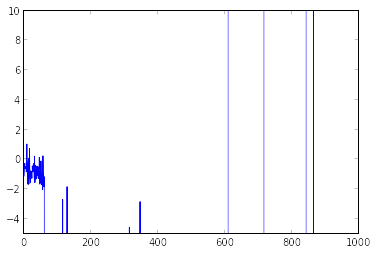

In [8]:
plot(Y[:, 0:1])
plt.ylim([-5, 10])

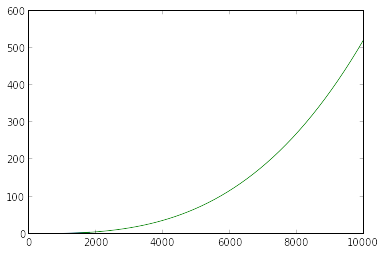

In [23]:
a_old = """200 0.177
400 0.436
600 0.845
800 1.365
1000 2.110
1200 2.995
1400 4.301
1600 5.655
1800 7.340
2000 9.373
2200 11.206
2400 13.273
2600 16.172
2800 20.010
3000 23.282
3200 27.882
3400 32.132
3600 37.140
3800 43.750"""

a = """200 0.041
400 0.133
600 0.313
800 0.539
1000 0.933
1200 1.432
1400 2.078
1600 2.932
1800 3.993"""

lines = a.split("\n")
ns = []
ts = []
for line in lines:
    n, t = line.split(" ")
    ns.append(int(n))
    ts.append(float(t))
    
    
plot(ns, ts)

r = np.polyfit(ns, ts, 3)
xs = np.linspace(500, 10000)
ys = np.polyval(r, xs)
plot(xs, ys)
